<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`
   3. sort lists of dated files even if they are sorted correctly by default on your machine

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Your Name:**

<img style="float: left;" src="colored-bar.png"/>

---

# Week 03- Lidar Data Compared to Ground Measurements: Understanding Uncertainty

This week you will work with LiDAR data. You will explore the values in a LiDAR dataset - specifically tree height from a canopy height model. You will compare these measurements to the same types of measurements made by humans in the field.

You can download the data for this week from earthpy using: 

`et.data.get_data('spatial-vector-lidar')`

For both the SJER and SOAP field sites, create scatterplots (with regression and 1:1 lines) that compare:
* **MAXIMUM** canopy height model height in meters, extracted within a 20 meter radius, compared to **MAXIMUM** tree
height derived from the *insitu* field site data.
* **MEAN** canopy height model height in meters, extracted within a 20 meter radius, compared to **MEAN** tree height derived from the *insitu* field site data.

Create one figure for each site with two subplots (ax1, ax2): one for the Max comparison and one for the Mean comparison.


## For All Plots

* Place lidar data values on the X axis and human measured tree height on the Y axis.
* Include a calculated **regression line** (HINT: use `sns.regplot()` to achieve this line) that describes the relationship of lidar of the data.
* Include a separate **1:1 line** that can be used to compare the regression fit to a perfect 1:1 fit. 
* Set the x and y limits to be the SAME for each individual plot. (e.g. for plot 3, the x and y limits are set to the same range). 
* Label x and y axes appropriately - include units.
* Add a title to your plot that describes what the plot shows.
* Ensure that your notebook is fully reproducible. This means you will:
   * Create reproducible paths using the os module
   * Download the data using code in the notebook


READINGS: Week 3
New Material:

Chap 6 on Uncertainty in Remote Sensing Data in Section 4Links to an external site. of the Intermediate Earth Data Science Textbook
https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/

Chapter 21: Lidar Data OverviewLinks to an external site.
https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/

Other Readings on Uncertainty:
Lidar UncertaintyLinks to an external site.
Uncertainty Terms - Systematic vs RandomLinks to an external site.
Land Cover Change and UncertaintyLinks to an external site.
Past Material That Could Be Helpful to Review:

Sections 2 and 3 on Intro to Vector and Raster Data of the Intermediate Earth Data Science TextbookLinks to an external site.
https://www.earthdatascience.org/courses/use-data-open-source-python/

Section 2 on Plotting Spatial Data of the Plotting TextbookLinks to an external site.
https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/


![Colored Bar](colored-bar.png)

## Set up your analysis

In the following cell, import the libraries you use in this notebook, and change your working directory so that your paths are reproducible. Note that `earthpy` will download the data to `~` > `earth-analytics` > `data` >`spatial-vector-lidar`

In [182]:
import os
import pathlib
import earthpy as et
import earthpy.plot as ep
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterstats as rs
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

In [44]:
# Set up paths for the project.

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)

os.chdir(home_dir)

# Create an output dir for created files.
output_path = os.path.join(home_dir, 'outputs')
if not os.path.isdir(output_path):
    os.makedir(output_path)

sjer_base_dir = os.path.join(
    'california',
    'neon-sjer-site',
)

# Ground based measurements.
sjer_insitu_path = os.path.join(
    sjer_base_dir,
    '2013',
    'insitu',
    'veg_structure', 
    'D17_2013_SJER_vegStr.csv',
)

# Lidar Canopy Height Model
sjer_lidar_chm_path = os.path.join(
    sjer_base_dir,
    '2013',
    'lidar',
    'SJER_lidarCHM.tif'
)

sjer_plots_path = os.path.join(
    sjer_base_dir,
    'vector_data',
    'SJER_plot_centroids.shp'
)

In [41]:
# Plot lidar and points
def plot_data(lidar, points):

    fig, ax = plt.subplots(figsize=(10, 10))
    lidar.plot(ax=ax)
    points.plot(ax=ax, marker='s', markersize=150, color='red')
    plt.show()


In [157]:
# Download the dataset that contains everything needed for the project.
et.data.get_data('spatial-vector-lidar')

# ----------- OPEN and PROCESS LIDAR CHM ------------------------ #
# --------------------------------------------------------------- #
sjer_lidar_chm = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

# Clean up the lidar file.
sjer_lidar_chm_clean = sjer_lidar_chm.where(sjer_lidar_chm > 0, np.nan)
# Plot it up and look.
#plot_data(sjer_lidar_chm, sjer_plots_gdf)

# --------------- OPEN SJER PLOT CENTROIDS & BUFFER ------------ #
# -------------------------------------------------------------- #
sjer_plots_gdf = gpd.read_file(sjer_plots_path)
# reset the geometry to the buffer version.
sjer_plots_gdf.geometry = sjer_plots_gdf.geometry.buffer(20)
sjer_plots_gdf.head()

# Name and location of the buffered insitu measurement sites.
plot_buffer_path = os.path.join(output_path, "sjer_plot_buffer.shp")
# Create the buffered file.
sjer_plots_gdf.to_file(plot_buffer_path)

# ----------- CALCULATE LIDAR ZONAL STATS (from rasterstats) ----- #
sjer_lidar_chm_stats = rs.zonal_stats(
    plot_buffer_path,
    sjer_lidar_chm_clean.values,
    stats=['mean', 'max'],
    affine=sjer_lidar_chm_clean.rio.transform(),
    geojson_out=True, nodata=0, copy_properties=True,
)
# Stick it in a dataframe.
sjer_lidar_chm_stats_gdf = gpd.GeoDataFrame.from_features(sjer_lidar_chm_stats)

# Rename df columns.
sjer_lidar_chm_stats_gdf.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean'},
    inplace=True
)


<xarray.DataArray (y: 5059, x: 4296)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 8.12     ,  9.19     , 10.04     , ...,        nan,        nan,
               nan],
       [ 8.09     ,  8.51     ,  9.3      , ...,        nan,        nan,
               nan],
       [ 7.6699996,  7.95     ,  8.2699995, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 2.546e+05 2.546e+05 ... 2.589e+05 2.589e+05
  * y            (y) float64 4.112e+06 4.112e+06 ... 4.107e+06 4.107e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  45.879997253418
    STATISTICS_MEAN:     1.#SNAN
    STATISTICS_MINIMUM:  0
    STATISTICS_STD

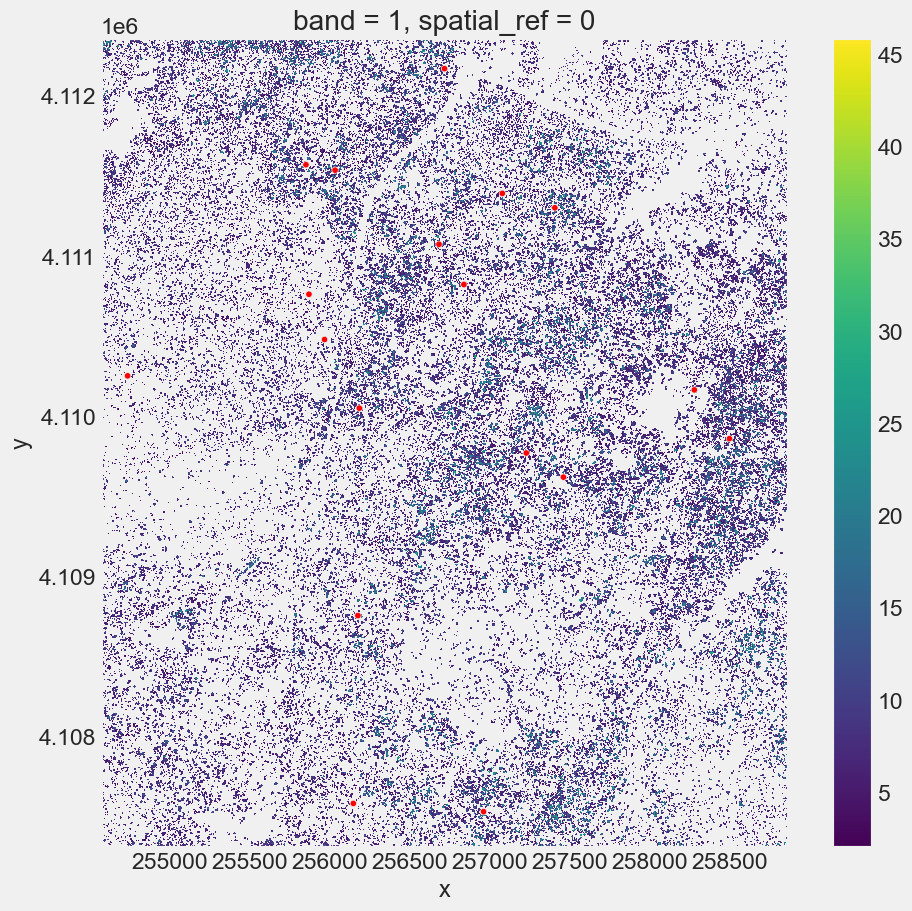

In [226]:
plot_data(sjer_lidar_chm_clean, sjer_plots_gdf)

![Colored Bar](colored-bar.png)

## SJER Lidar vs Insitu Comparison Plots
You will use the following SJER data for this figure:
* `spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv`
* `spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp`

Create a figure with 2 subplots for the NEON San Joaquin Experimental Range (SJER) field site.
* Plot 1 should show **max** lidar vs insitu height with lidar on the x axis and insitu height on the y axis.
* Plot 2 should show **mean** lidar vs insitu height with lidar on the x axis and insitu height on the y axis.

For each plot:
1. Set the x and y lims to be the same range: `(0, 30)` using `xlim=` and `ylim=`. This will make the plots more comparable.
2. Add a title that includes the field site name and the measurement being displayed (max or min height).
3. Add a 1:1 line to each plot.
4. Add a regression line using `sns.regplot()`. SNS is the alias for the seaborn plotting package (`import seaborn as sns`).

To create this plot, you will need to calculate a summary data frame for each site that contains both the lidar mean and max values and insitu (measured on the ground by humans) mean and max values. In the following cell, compute the summary values for the LiDAR data. **For the tests to work, rename your summary columns `lidar_max` and `lidar_mean`, and call your `GeoDataFrame`at the end of your answer cell.**


In [ ]:
# --------------- OPEN INSITU SJER PLOT CENTROIDS ------------ #
# -------------------------------------------------------------- #
sjer_insitu_gdf = gpd.read_file(sjer_insitu_path)

# reset the geometry to the buffer version.

# Reduce the columns to only what we need.
sjer_insitu_gdf = sjer_insitu_gdf[["siteid",
                               "sitename",
                               "plotid",
                               "stemheight",
                               "scientificname"]]

# This solves an oddity.  The 'stemheight' column is not coming out as numeric.
# We need to change the datatype to a float.  As a float .mean and .max will work.
sjer_insitu_gdf["stemheight"] = pd.to_numeric(sjer_insitu_gdf["stemheight"], downcast="float")

# ------------ Create new df of insitu stem height and stats. ---------------- #
# Create a df to include max and mean height.
insitu_stem_height_df = sjer_insitu_gdf.groupby('plotid')['stemheight'].agg(['max', 'mean'])

# Rename column names to be more explanatory/
insitu_stem_height_df.rename(
    columns={ "mean": "insitu_mean", "max": "insitu_max"},
    inplace=True
    )  
# The index is plotid but we just want 0 ... 9 ...
insitu_stem_height_df = insitu_stem_height_df.reset_index()
insitu_stem_height_df.head()

# -------------- MERGE Insitu df with LIDAR df ---------------- #

# Join lidar and human measured tree height data
sjer_all_heights_gdf = sjer_lidar_chm_stats_gdf.merge(insitu_stem_height_df,
                                               left_on='Plot_ID',
                                               right_on='plotid')

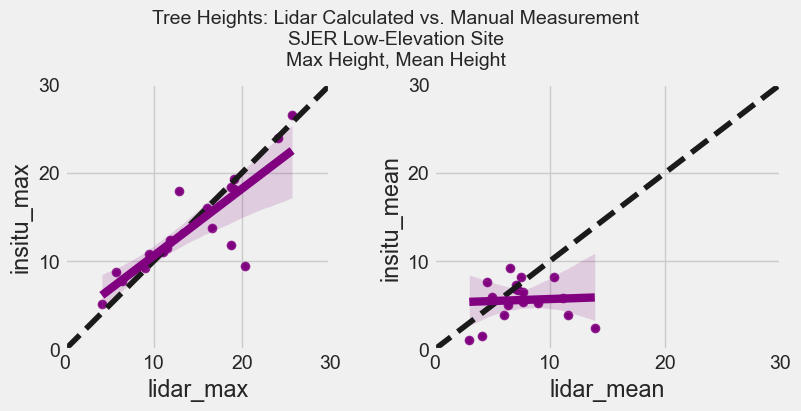

In [227]:
# PLOTTING CODE ------------------------------------------------

# Why do I need to convert from a gdf to a df in order to plot?
sjer_all_heights_df = pd.DataFrame(sjer_all_heights_gdf)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4), layout="constrained")

sjer_all_heights_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14, s=20,
                          color="purple",
                          ax=ax1
                          )
                          
sjer_all_heights_df.plot('lidar_mean',
                          'insitu_mean',
                          kind='scatter',
                          fontsize=14, s=20,
                          color="purple",
                          ax=ax2
                          )

ax1.set(xlim=[0, 30], ylim=[0, 30])
ax1.set_aspect('equal')
ax2.set(xlim=[0, 30], ylim=[0, 30])

# Add 1:1 lines ---------
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')

sns.regplot(x='lidar_max', y='insitu_max', data=sjer_all_heights_df, color="purple", ax=ax1)
sns.regplot(x='lidar_mean', y='insitu_mean', data=sjer_all_heights_df, color="purple", ax=ax2)

(fig.suptitle(
    "Tree Heights: Lidar Calculated vs. Manual Measurement\n"
    "SJER Low-Elevation Site\n"
    "Max Height, Mean Height", size='medium')
)

plt.show()


In [ ]:
# NBGRADER
# Tests that the new columns exist and have the correct values
# IMPORTANT: Make sure you called the dataframe with the new columns at the end of the above cell.
# Do not modify this cell
student_sjer_lidar_sum = _
student_sjer_lidar_points = 0

if isinstance(student_sjer_lidar_sum, gpd.GeoDataFrame):
    print("\u2705 Great job! Your data are stored in a GeoDataFrame!")
    student_sjer_lidar_points += 1
else:
    print("\u274C Oops, the data are not stored in a GeoDataFrame.")

student_colunms = student_sjer_lidar_sum.columns

if 'lidar_max' in student_colunms:
    print("\u2705 Dataset has the correct column name for the maximum values!")
    student_sjer_lidar_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the maximum values.")

if 'lidar_mean' in student_colunms:
    print("\u2705 Dataset has the correct column name for the mean values!")
    student_sjer_lidar_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the mean values.")

if round(sjer_lidar_mean_max_answer.lidar_max.mean(), 2)==14.46:
    print("\u2705 Great - you correctly calculated the maximum values "
          "for each plot from lidar values!")
    student_sjer_lidar_points += 2
else:
    print("\u274C Oops - looks like your data frame values were not "
          "correct.")

if round(sjer_lidar_mean_max_answer.lidar_mean.mean(), 2)==7.56:
    print("\u2705 Great - you correctly calculated the mean values for each "
          "plot from lidar values!")
    student_sjer_lidar_points += 2
else:
    print("\u274C Oops - looks like your data frame values were not correct.")

print("\n \u27A1 You received {} out of 7 points for calculating "
      "lidar values.".format(student_sjer_lidar_points))

student_sjer_lidar_points

In the following cell, compute the summary values for the insitu data, and merge the results with the LiDAR GeoDataFrame. **Name the new columns `insitu_max` and `insitu_mean` and call the completed `GeoDataFrame` at the end of you answer cell for the tests to work**

In [ ]:
print (sjer_plots_gdf.groupby('Plot_ID').mean())

In [ ]:
# NBGRADER
# Tests that the new columns exist and have the correct values
# IMPORTANT: Make sure you called the dataframe with the new columns at the end of the above cell.
# Do not modify this cell

student_sjer_insitu_sum = _
student_sjer_insitu_points = 0

if isinstance(student_sjer_insitu_sum, gpd.GeoDataFrame):
    print("\u2705 Great job! Your data are stored in a GeoDataFrame!")
    student_sjer_insitu_points += 1
else:
    print("\u274C Oops, the data are not stored in a GeoDataFrame.")

student_columns = student_sjer_insitu_sum.columns

if 'insitu_max' in student_columns:
    print("\u2705 Dataset has the correct column name for the maximum values!")
    student_sjer_insitu_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the maximum values.")

if 'insitu_mean' in student_columns:
    print("\u2705 Dataset has the correct column name for the mean values!")
    student_sjer_insitu_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column "
          "name for the mean values.")
    
if 'lidar_mean' in student_columns and 'lidar_max' in student_columns:
    print("\u2705 Dataset correctly merged!")
    student_sjer_insitu_points += 1
else:
    print("\u274C Oops, the insitu and lidar datasets were not merged.")


if round(student_sjer_insitu_sum.insitu_max.mean(), 2)==13.98:
    print("\u2705 Great - you correctly calculated the maximum values for "
          "each plot from insitu values!")
    student_sjer_insitu_points += 2
else:
    print("\u274C Oops - looks like your data frame values were not correct.")

if round(student_sjer_insitu_sum.insitu_mean.mean(), 2)==5.61:
    print("\u2705 Great - you correctly calculated the mean values for "
          "each plot from lidar values!")
    student_sjer_insitu_points += 2
else:
    print("\u274C Oops - looks like your data frame values were not correct.")

print("\n \u27A1 You received {} out of 8 points for calculating "
      "insitu values.".format(student_sjer_insitu_points))
student_sjer_insitu_points

In [ ]:
In the cell below, plot the SJER data as specified above.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Figure 2: Plots 3 & 4 - SOAP Lidar vs Insitu Comparison Plots (15 points for each subplot)

You will use the following SOAP data for this figure:
* `spatial-vector-lidar/california/neon-soap-site/2013/insitu/veg-structure/D17_2013_SOAP_vegStr.csv`
* `spatial-vector-lidar/california/neon-soap-site/vector_data/SOAP_centroids.shp`

Create a figure with 2 subplots for the NEON Soaproot Saddle (SOAP) field site.
* Plot 1 should show **max** lidar vs insitu height with lidar on the x axis and insitu height on the y axis.
* Plot 2 should show **mean** lidar vs insitu height with lidar on the x axis and insitu height on the y axis.

For each plot:

1. Set the x and y lims to be the same range using `xlim=` and `ylim=`: 
    * `(0, 140)` for the SOAP Max height plot. 
    * `(0, 40)` for the SOAP Mean height plot. 
2. Add a title that includes the field site name and the measurement being displayed (max or min height).
3. Add a 1:1 line to each plot.
4. Add a regression line using `sns.regplot()`

To create this plot, you will need to calculate a summary data frame for each site that contains lidar mean and max values and insitu (measured on the ground by humans) mean and max values.

**HINT**: the SOAP data have some inconsistencies in the column headings. One way to fix this is to use the syntax: 

`"text-to-append-to-column" + dataframe_name["column-name-here"]`

In the following cell, import and process the SOAP data like you did the SJER data. **Make sure to call your combined `GeoDataFrame` at the end of cell for the test cell to work.**

In [ ]:
# Set up new paths for the SOAP data.

soap_base_dir = os.path.join(
    'california',
    'neon-soap-site',
)

# Ground based measurements.
soap_insitu_path = os.path.join(
    soap_base_dir,
    '2013',
    'insitu',
    'veg-structure', 
    'D17_2013_SOAP_vegStr.csv',
)

# Lidar Canopy Height Model
soap_lidar_chm_path = os.path.join(
    soap_base_dir,
    '2013',
    'lidar',
    'SOAP_lidarCHM.tif'
)

soap_plots_path = os.path.join(
    soap_base_dir,
    'vector_data',
    'SOAP_centroids.shp'
)

In [ ]:
# ----------- OPEN and PROCESS SOAP LIDAR CHM ------------------------ #
# ------------------------------------------------------------------- #
soap_lidar_chm = rxr.open_rasterio(soap_lidar_chm_path, masked=True).squeeze()

# Clean up the lidar file.
soap_lidar_chm_clean = soap_lidar_chm.where(soap_lidar_chm > 0, np.nan)
# Plot it up and look.
# plot_data(soap_lidar_chm, soap_plots_gdf)

# --------------- OPEN SOAP PLOT CENTROIDS & BUFFER ------------ #
# -------------------------------------------------------------- #
soap_plots_gdf = gpd.read_file(soap_plots_path)
# reset the geometry to the buffer version.
soap_plots_gdf.geometry = soap_plots_gdf.geometry.buffer(20)

# Name and location of the buffered insitu measurement sites.
plot_buffer_path = os.path.join(output_path, "soap_plot_buffer.shp")
# Create the buffered file.
soap_plots_gdf.to_file(plot_buffer_path)

# ----------- CALCULATE LIDAR ZONAL STATS (from rasterstats) ----- #
soap_lidar_chm_stats = rs.zonal_stats(
    plot_buffer_path,
    soap_lidar_chm_clean.values,
    stats=['mean', 'max'],
    affine=soap_lidar_chm_clean.rio.transform(),
    geojson_out=True, nodata=np.nan, copy_properties=True,
)
# Stick stats in a dataframe.
soap_lidar_chm_stats_gdf = gpd.GeoDataFrame.from_features(soap_lidar_chm_stats)

# Rename df columns.
# ID becomes plotid to match the insitu column name.
# Will need to add 'SOAP' to ID values to exactly match the insitu col name.
soap_lidar_chm_stats_gdf.rename(
    columns={'max': 'lidar_max', 'mean': 'lidar_mean', 'ID': 'plotid'},
    inplace=True
)

# Add 'SOAP' to all id values. Now it will be mergable with
# the insitu dataframe.
soap_lidar_chm_stats_gdf['plotid'] = 'SOAP' + soap_lidar_chm_stats_gdf['plotid']


In [ ]:
# --------------- OPEN INSITU SOAP PLOT CENTROIDS ------------ #
# ------------------------------------------------------------ #
soap_insitu_gdf = gpd.read_file(soap_insitu_path)

# reset the geometry to the buffer version.

# Reduce the columns to only what we need.
soap_insitu_gdf = soap_insitu_gdf[["siteid",
                               "sitename",
                               "plotid",
                               "stemheight",
                               "scientificname"]]

# This solves an oddity.  The 'stemheight' column is not coming out as numeric.
# We need to change the datatype to a float.  As a float .mean and .max will work.
soap_insitu_gdf["stemheight"] = pd.to_numeric(soap_insitu_gdf["stemheight"], downcast="float")

# ------------ Create new df of insitu stem height and stats. ---------------- #
# Create a df to include max and mean height.
insitu_stem_height_df = soap_insitu_gdf.groupby('plotid')['stemheight'].agg(['max', 'mean'])

# Rename column names to be more explanatory/
insitu_stem_height_df.rename(
    columns={ "mean": "insitu_mean", "max": "insitu_max"},
    inplace=True
    )  
# The index is plotid but we just want 0 ... 9 ...
insitu_stem_height_df = insitu_stem_height_df.reset_index()

# -------------- MERGE Insitu df with LIDAR df ---------------- #

# Join lidar and human measured tree height data
soap_all_heights_gdf = soap_lidar_chm_stats_gdf.merge(insitu_stem_height_df,
                                               left_on='plotid',
                                               right_on='plotid')
soap_all_heights_gdf.head()


In [ ]:
# NBGRADER

student_soap_gdf = _
student_soap_points = 0

if isinstance(student_soap_gdf, gpd.GeoDataFrame):
    print("\u2705 Great job! Your data are stored in a GeoDataFrame!")
    student_soap_points += 1
else:
    print("\u274C Oops, the data are not stored in a GeoDataFrame.")

student_columns = student_soap_gdf.columns

if 'lidar_max' in student_columns:
    print("\u2705 Dataset has the correct column name for the maximum "
          "values!")
    student_soap_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column "
          "name for the maximum values.")

if 'lidar_mean' in student_columns:
    print("\u2705 Dataset has the correct column name for the mean values!")
    student_soap_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the mean values.")

if 'insitu_max' in student_colunms:
    print("\u2705 Dataset has the correct column name for the maximum values!")
    student_soap_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the maximum values.")

if 'insitu_mean' in student_colunms:
    print("\u2705 Dataset has the correct column name for the mean values!")
    student_soap_points += 1
else:
    print("\u274C Oops, the dataset does not have the correct column name "
          "for the mean values.")

student_summary = (
    student_soap_gdf
   [['lidar_max', 'lidar_mean', 'insitu_max', 'insitu_mean']]
   .mean()
   .apply(lambda x: round(x, 2))
   .values)

if all(student_summary==[33.54, 13.87, 40.68,  5.06]):
    print("\u2705 Great - you correctly calculated summary values!")
    student_soap_points += 8
else:
    print("\u274C Oops - looks like your data frame values were not correct.")

print("\n \u27A1 You received {} out of 13 points for calculating lidar "
      "values.".format(student_soap_points))
student_soap_points


### In the cell below plot the SOAP site values the same way your plotted the SJER site values

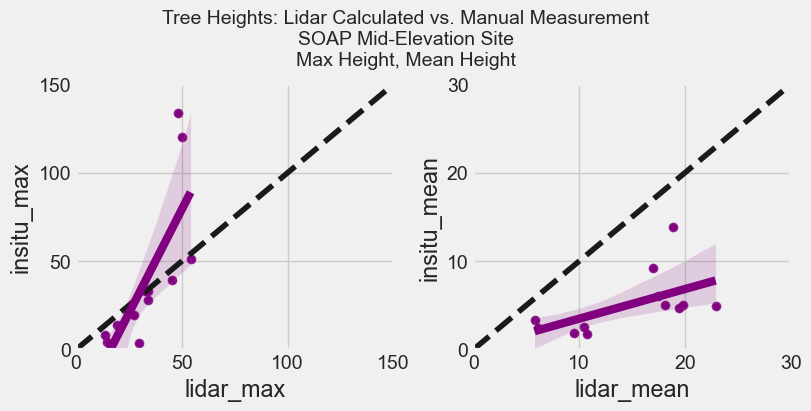

In [225]:
# PLOTTING CODE ------------------------------------------------

# Why do I need to convert from a gdf to a df in order to plot?
soap_all_heights_df = pd.DataFrame(soap_all_heights_gdf)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4), layout="constrained")

soap_all_heights_df.plot('lidar_max',
                          'insitu_max',
                          kind='scatter',
                          fontsize=14, s=20,
                          color="purple",
                          ax=ax1
                          )
                          
soap_all_heights_df.plot('lidar_mean',
                          'insitu_mean',
                          kind='scatter',
                          fontsize=14, s=20,
                          color="purple",
                          ax=ax2
                          )

ax1.set(xlim=[0, 150], ylim=[0, 150])
ax2.set(xlim=[0, 30], ylim=[0, 30])

# Add 1:1 lines ---------
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')

sns.regplot(x='lidar_max', y='insitu_max', data=soap_all_heights_df, color="purple", ax=ax1)
sns.regplot(x='lidar_mean', y='insitu_mean', data=soap_all_heights_df, color="purple", ax=ax2)

(fig.suptitle(
    "Tree Heights: Lidar Calculated vs. Manual Measurement\n"
    "SOAP Mid-Elevation Site\n"   
    "Max Height, Mean Height", size='medium')
)

plt.show()

![Colored Bar](colored-bar.png)

## Question 1 Figure One: SJER mean vs max height -- Plots 1 and 2 Interpretation
In the markdown cell below, answer the following questions:

1. Looking at the plots above, which metric: mean or max height, has a stronger relationship or is closer to a one:one relationship?
2. List one reason why mean or max (whatever you answered for question 1 above) has a stronger relationship.

You answers can be brief -- a single word or sentence or two is fine. 

YOUR ANSWER HERE

![Colored Bar](colored-bar.png)


## Question 2. Of all four relationships that you plotted above, which site (SOAP or SJER) and metric (mean or max height) showed the strongest relationship? 

**A strong relationship is one that is closer to 1:1 in this case.**

Add your answer in the markdown cell below. It can be short - 2-5 sentences. You do not need to perform any additional calculations. Consider the readings and the data and suggest why a particular metric might have a strong relationship.

YOUR ANSWER HERE

![Colored Bar](colored-bar.png)

## Question 3. List 2 reasons why lidar max height values may be larger than human measurements.

Add your answer to the markdown cell below.

YOUR ANSWER HERE

![Colored Bar](colored-bar.png)

## Question 4. List 2 systematic sources of error could impact differences between lidar and measured tree height values ( 5 points)

Add your answer in the markdown cell below.

YOUR ANSWER HERE

![Colored Bar](colored-bar.png)

## Question 5. List 2 random sources of error that could impact differences between lidar and measured tree height values.  (5 points)

Add your answer to the markdown cell below. Note that you can provide sources of random error for lidar OR insitu measurements. You only need two total examples. 

YOUR ANSWER HERE

![Colored Bar](colored-bar.png)


# Do not edit this cell!
* Notebook begins at cell [1] and runs on any machine in its entirety.
* Pep8 format is applied throughout.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module
   * data downloaded using code in the notebook.